# Quick Start

This quick start guide provides an introduction to the data science library designed for capital markets. We'll be following the use case of predicting trading volume in the next 10 minutes. A graphical overview of the main components of the library appears below.

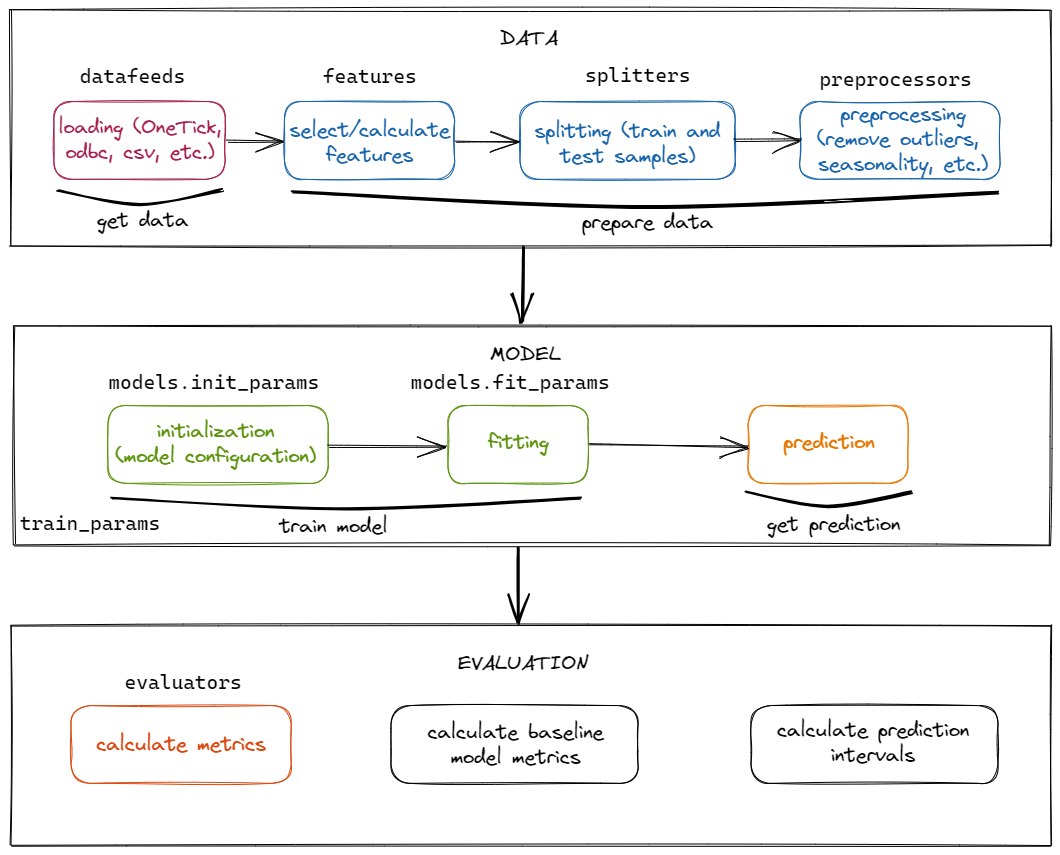

# Running an experiment

An end-to-end experiment with the stages from the diagram above is specified as follows:

In [2]:
import os
import onetick.py as otp
import pandas as pd
import yaml

import dsframework
from dsframework.utils.func import build_experiment, build_experiment_class
from dsframework.impl.data_pipelines import CalcLags, OneTickBarsDatafeed, SplitXYTrainTest
from dsframework.impl.evaluators import MAPEEvaluator, R2Evaluator
from dsframework.impl.experiments import Experiment
from dsframework.impl.models import CatBoostRegressor
print(dsframework.__version__)
start = otp.dt(2020, 11, 10, 9, 30)
end = otp.dt(2022, 11, 10, 16, 0)


class VolumePrediction(Experiment):
    # DATA
    datafeeds = [
        OneTickBarsDatafeed(
            db="NYSE_TAQ_BARS",
            tick_type="TRD_1M",
            symbols=["SPY"],
            start=start,
            end=end,
            bucket=600,
        )
    ]
    features = [CalcLags(periods=[1, 2, 3, 39, 40], columns=["VOLUME"])]

    splitters = [
        SplitXYTrainTest(columns_to_predict=["VOLUME"], test_size=0.15, val_size=0.15)
    ]

    preprocessors = []

    # MODEL
    models = [
        CatBoostRegressor(
            init_params={
                "iterations": [100],
                "learning_rate": [0.05],
                "l2_leaf_reg": [2],
                "depth": [2],
            }
        )
    ]

    train_params = {"verbose": 0}

    # EVALUATION
    evaluators = [MAPEEvaluator(), R2Evaluator()]

0.0.88


It takes one line to run the experiment. Or four if you'd like to see the intermediate results.

In [3]:
exp = VolumePrediction()

exp.run()
# or equivalently:
# exp.get_data()
# exp.prepare_data()
# exp.init_fit()
# exp.predict(x=exp.x_test)

# output the model's parameters
print(exp.current_model_params)
# and the metrics
exp.calc_metrics()

{'depth': 2, 'iterations': 100, 'l2_leaf_reg': 2, 'learning_rate': 0.05}


{'VOLUME_MAPE': 0.25365359159866696, 'VOLUME_R2': 0.6757962430452076}

Export the details of the experiment into a dict or a yaml file to share with others, to reproduce the experiment, or to tweak the config to try another experiment.

In [4]:
config = exp.serialize_config()
config

{'general': {'experiment_name': 'default_experiment',
  'log_models': False,
  'mlflow_url': None},
 'datafeeds': [{'db': 'NYSE_TAQ_BARS',
   'tick_type': 'TRD_1M',
   'symbols': ['SPY'],
   'start': [2020, 11, 10, 9, 30],
   'end': [2022, 11, 10, 16],
   'bucket': 600,
   'timezone': 'EST5EDT',
   'class': 'dsframework.impl.OneTickBarsDatafeed',
   'use': True}],
 'features': [{'columns': ['VOLUME'],
   'periods': [1, 2, 3, 39, 40],
   'use_as_inputs': True,
   'column_with_groups': '',
   'suffix': '_lag_',
   'class': 'dsframework.impl.CalcLags',
   'use': True}],
 'splitters': [{'columns_to_predict': ['VOLUME'],
   'shuffle': False,
   'val_size': 0.15,
   'test_size': 0.15,
   'class': 'dsframework.impl.SplitXYTrainTest',
   'use': True}],
 'models': [{'init_params': {'iterations': [100],
    'learning_rate': [0.05],
    'l2_leaf_reg': [2],
    'depth': [2]},
   'fit_params': {},
   'class': 'dsframework.impl.CatBoostRegressor',
   'use': True}],
 'evaluators': [{'class': 'dsframe

 # Hyperparameter Tuning and Cross Validation

Specify a list of possible values for each hyperparameter to run a grid or random search. Each combinations of hyperparameters will be evaluated based either on the validation set (`val_type: Simple`) or using expanding window Walk-Forward validation with the given number of folds.

In [5]:
from dsframework.impl.models import CatBoostRegressor

VolumePrediction = build_experiment_class(config)

VolumePrediction.models = [
    CatBoostRegressor(
        init_params={
            "iterations": [100, 500],
            "learning_rate": [.01, .05, .1],
            "l2_leaf_reg": [1, 2, 3],
            "depth": [1, 2, 3],
        }
    )
]

VolumePrediction.train_params = {
    "search_cv": {
        "val_type": "WalkForward",  # Simple, Cross, WalkForward
        "folds": 5,
        "eval_metric": "MAPE",
        "search_optimization": "grid", # grid, random
    },
    "verbose": 0,
}

exp = VolumePrediction()

exp.run()

# output the best parameters
print(exp.current_model_params)
# and the metrics
exp.calc_metrics()

{'depth': 3, 'iterations': 500, 'l2_leaf_reg': 2, 'learning_rate': 0.05}


{'VOLUME_MAPE': 0.24579720410616382, 'VOLUME_R2': 0.737103970929533}

Results from walk-forward validation are available for analysis. The value of the `search_cv.eval_metric` metric specified in `train_params` is shown for each fold and for each setting of the hyperparameters. Note that individual loss values are multiplied by -1 to be consistent with the maximization problem used by sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [6]:
pd.DataFrame(exp.gscv_model.cv_results_).drop(['params'], axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110731,0.030932,0.002276,0.000060,1,100,1,0.01,-0.403088,-0.658935,-0.634629,-0.565704,-0.288754,-0.510222,0.142265,53
1,0.110962,0.031618,0.002305,0.000033,1,100,1,0.05,-0.319000,-0.364040,-0.367974,-0.332653,-0.236710,-0.324075,0.047448,41
2,0.111616,0.034261,0.002316,0.000038,1,100,1,0.1,-0.315560,-0.328486,-0.333501,-0.305248,-0.240929,-0.304745,0.033407,37
3,0.110849,0.030277,0.002267,0.000032,1,100,2,0.01,-0.403303,-0.658784,-0.634010,-0.566718,-0.287616,-0.510086,0.142528,52
4,0.108927,0.033234,0.002289,0.000068,1,100,2,0.05,-0.318989,-0.364839,-0.368247,-0.331608,-0.236098,-0.323956,0.047823,40
5,0.110197,0.032747,0.002364,0.000046,1,100,2,0.1,-0.315912,-0.330294,-0.335732,-0.305161,-0.239925,-0.305405,0.034460,39
6,0.106775,0.032482,0.002323,0.000115,1,100,3,0.01,-0.403058,-0.658960,-0.634609,-0.566671,-0.288495,-0.510358,0.142428,54
7,0.114796,0.031604,0.002420,0.000154,1,100,3,0.05,-0.319352,-0.366006,-0.369993,-0.331015,-0.236401,-0.324554,0.048213,42
8,0.110881,0.031123,0.002421,0.000138,1,100,3,0.1,-0.315962,-0.328990,-0.333338,-0.305893,-0.239609,-0.304758,0.033986,38
9,0.393992,0.155811,0.003049,0.000428,1,500,1,0.01,-0.318464,-0.367007,-0.370684,-0.333743,-0.236239,-0.325227,0.048681,43


# Choosing the optimal model

You can compare multiple models and do hyperparameter tuning in the same experiment.

Five models are compated in the example below. Two of them (CatBoost and XGBoost) are tuned to find the best hyperparameters using grid search and walk-forward validation with 5 folds, while the other three are used with the default hyperparameters.

In [18]:
from dsframework.impl.models import (
    CatBoostRegressor,
    DecisionTreeRegressor,
    DNNRegressor,
    RandomForestRegressor,
    XGBRegressor,
)

VolumePrediction = build_experiment_class(config)

VolumePrediction.models = [
    CatBoostRegressor(
        init_params={
            "iterations": [100, 500],
            "learning_rate": [.01, .05, .1],
            "l2_leaf_reg": [2, 3],
            "depth": [2, 3],
        }
    ),
    XGBRegressor(
        init_params={
            "learning_rate": [.03, .01, .1],
            "n_estimators": [100, 500],
            "max_depth": [3, 2, 4],
            "min_child_weight": [2, 4],
            "max_delta_step": [0],
            "subsample": [0.9],
            "nthread": [2],
        }
    ),
    DNNRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
]

# example of setting cross-validation parameters
VolumePrediction.train_params = {
    "search_cv": {
        "val_type": "WalkForward",  # Simple, Cross, WalkForward
        "folds": 5,
        "eval_metric": "MAPE",
        "search_optimization": "grid",
    },
    "verbose": 0,
}

exp = VolumePrediction()

exp.run()

print(f'optimal model: {exp.native_model.__class__.__name__}')
print(f'model hyperparameters: {exp.current_model_params}.')
exp.calc_metrics()

74/74 [==============================] - 0s 808us/step
optimal model: XGBRegressor
model hyperparameters: {'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'nthread': 2, 'subsample': 0.9}.


{'VOLUME_MAPE': 0.2297151940391801, 'VOLUME_R2': 0.7231435013258467}

In [8]:
exp.models_cv_score

{'CatBoostRegressor_id0': -0.2801551215023274,
 'XGBRegressor_id1': -0.26439253728610723,
 'DNNRegressor_id2': -0.3111068719400791,
 'DecisionTreeRegressor_id3': -0.3912938288395181,
 'RandomForestRegressor_id4': -0.28214932723220765}

In [9]:
exp.dsf_model

In [10]:
exp.current_model_params

{'learning_rate': 0.03,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 100,
 'nthread': 2,
 'subsample': 0.9}

# Feature Engineering

You can run experiments with different sets of features to choose the optimal ones. A stylized example below compares including increasing number of `lags` into the set of features. 

In [11]:
VolumePrediction = build_experiment_class(config)

df = VolumePrediction().get_data()

# Calculate metrics for each set of lag features
for i in range(3, 11):
    lags = list(range(1, i))
    VolumePrediction.features = [CalcLags(periods=None, columns=["VOLUME"])]
    exp = VolumePrediction()
    exp.prepare_data(df=df)
    exp.init_fit()
    exp.predict(x=exp.x_test)
    print(f"lags: {str(lags)}:", exp.calc_metrics())

lags: [1, 2]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}
lags: [1, 2, 3]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}
lags: [1, 2, 3, 4]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}
lags: [1, 2, 3, 4, 5]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}
lags: [1, 2, 3, 4, 5, 6]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}
lags: [1, 2, 3, 4, 5, 6, 7]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}
lags: [1, 2, 3, 4, 5, 6, 7, 8]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}
lags: [1, 2, 3, 4, 5, 6, 7, 8, 9]: {'VOLUME_MAPE': 0.30880226412545453, 'VOLUME_R2': 0.4003020687738852}


# Train models for different symbols

In [12]:
from dsframework.impl import OneTickBarsDatafeed

VolumePrediction = build_experiment_class(config)

symbols = ["SPY", "QQQ", "VOO"]
VolumePrediction.datafeeds = [
    OneTickBarsDatafeed(
        db="NYSE_TAQ_BARS",
        tick_type="TRD_1M",
        symbols=symbols,
        start=start,
        end=end,
        bucket=600,
    )
]
exp = VolumePrediction()
df = exp.get_data()
for symbol in symbols:
    symbol_df = df.loc[df['TICKER']==symbol]
    exp.prepare_data(symbol_df)
    exp.init_fit()
    exp.predict(x=exp.x_test)
    print(f'{symbol}: {exp.calc_metrics()}')

SPY: {'VOLUME_MAPE': 0.25365359159866696, 'VOLUME_R2': 0.6757962430452076}
QQQ: {'VOLUME_MAPE': 0.2615296849135726, 'VOLUME_R2': 0.5855350269407161}
VOO: {'VOLUME_MAPE': 0.5043951137705959, 'VOLUME_R2': 0.2670579798299093}


# Adding a feature
## Features based on the data already in the training set: e.g., the time of day

In [13]:
from dsframework.impl import SelectColumns

VolumePrediction = build_experiment_class(config)

VolumePrediction.features = [
    CalcLags(periods=[1, 2, 3, 39, 40], columns=["VOLUME"]),
    SelectColumns(columns=["feature_hhmm"]),
]

exp = VolumePrediction()

df = exp.get_data()

# Calculate custom feature "feature_hhmm"
df["feature_hhmm"] = pd.to_datetime(df["Time"]).dt.strftime("%H%M")

exp.prepare_data(df=df)

exp.x_train

,VOLUME_lag_1,VOLUME_lag_2,VOLUME_lag_3,VOLUME_lag_39,VOLUME_lag_40,feature_hhmm
40,2003668.0,6654316.0,2171714.0,2360979.0,2793348.0,0951
41,1713759.0,2003668.0,6654316.0,2001420.0,2360979.0,1001
42,1510836.0,1713759.0,2003668.0,1877218.0,2001420.0,1011
43,1144172.0,1510836.0,1713759.0,1437090.0,1877218.0,1021
44,885056.0,1144172.0,1510836.0,1463968.0,1437090.0,1031
...,...,...,...,...,...,...
14198,1762711.0,1823729.0,1544804.0,1644922.0,1735131.0,1201
14199,1829888.0,1762711.0,1823729.0,1514355.0,1644922.0,1211
14200,2246901.0,1829888.0,1762711.0,1652656.0,1514355.0,1221
14201,1664084.0,2246901.0,1829888.0,1330055.0,1652656.0,1231


## Features based on other data: e.g., compute premarket volume from tick data
You the power of the tick management platform OneTick to retrieve features from market data. A pandas-like API that lets you define analytics to be computed in OneTick and return the results as a pandas DataFrame by calling `otp.run()`. See [onetick-py quick start quide](https://github.com/onemarketdata/otp-examples/blob/master/quick_start.ipynb).

In [14]:
from dsframework.interfaces.data_pipelines import BaseDatafeed


class CustomDatafeed(BaseDatafeed):
    def __init__(self, **kwargs):
        self.db = kwargs.get("db")
        self.tick_type = kwargs.get("tick_type")
        self.symbols = kwargs.get("symbols")
        self.start = kwargs.get("start")
        self.end = kwargs.get("end")
        self.bucket = kwargs.get("bucket")
        self.timezone = kwargs.get("timezone")
        self.suffix = kwargs.get("suffix")

    def load(self, *args):
        data_premarket = otp.DataSource(db='NYSE_TAQ', tick_type='TRD')
        data_premarket = data_premarket.agg(
            {
                "VOLUME_premarket": otp.agg.sum(data_premarket["SIZE"]),
            }
        )

        df = otp.run(
            data_premarket,
            apply_times_daily=True,
            start=self.start - otp.Hour(6),
            end=self.end - otp.Hour(6) - otp.Minute(30),
            symbols=self.symbols,
        )

        return df.set_index("Time")


start = otp.dt(2022, 11, 7, 9, 30)
end = otp.dt(2022, 11, 10, 16, 0)
VolumePrediction = build_experiment_class(config)

VolumePrediction.datafeeds = [
    OneTickBarsDatafeed(
        db="NYSE_TAQ_BARS",
        tick_type="TRD_1M",
        symbols=["AA"],
        start=start,
        end=end,
        bucket=600,
    ),
    CustomDatafeed(
        db="NYSE_TAQ",
        tick_type="TRD",
        symbols=["AA"],
        start=start,
        end=end,
        bucket=600,
    )
]


bars = VolumePrediction.datafeeds[0].load()
bars = bars.reset_index()
premarket = VolumePrediction.datafeeds[1].load()
premarket = premarket.reset_index()

VolumePrediction.features = [
    CalcLags(periods=[1, 2, 3, 39, 40], columns=["VOLUME"]),
    SelectColumns(columns=["VOLUME_premarket"]),
]


In [15]:
premarket['date'] = premarket['Time'].dt.date
bars['date'] = bars['Time'].dt.date
df = pd.merge(bars, premarket, on='date', suffixes=('','_pre'))
df = df.set_index("Time")
exp = VolumePrediction()
exp.prepare_data(df=df)

(                     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_39  VOLUME_lag_40  VOLUME_premarket
 Time                                                                                                         
 2022-11-08 09:51:00       73862.0      314698.0      133679.0       298593.0       247255.0             44835
 2022-11-08 10:01:00      105908.0       73862.0      314698.0       269939.0       298593.0             44835
 2022-11-08 10:11:00      187288.0      105908.0       73862.0       302665.0       269939.0             44835
 2022-11-08 10:21:00       96835.0      187288.0      105908.0       157196.0       302665.0             44835
 2022-11-08 10:31:00      130020.0       96835.0      187288.0       108725.0       157196.0             44835
 ...                           ...           ...           ...            ...            ...               ...
 2022-11-10 09:51:00      567786.0      406979.0      157127.0        93331.0       142831.0             71213
 

In [16]:
exp.init_fit()
exp.predict(x=exp.x_test)
exp.calc_metrics()

{'VOLUME_MAPE': 0.6151518366971754, 'VOLUME_R2': 0.2875033502995987}

# Use a custom model

You are free to choose any model even if we do not have it integrated yet.

In [17]:
from dsframework.impl.models import RegressorModel


class CustomModel(RegressorModel):
    from lightgbm import LGBMRegressor

    model_class = LGBMRegressor

    def init_model(self, dsf_params={}, init_params={}):
        super().init_model(dsf_params=dsf_params, init_params=init_params)

        self.model = self.model_class(
            **init_params,
        )


VolumePrediction.datafeeds = [
        OneTickBarsDatafeed(
            db="NYSE_TAQ_BARS",
            tick_type="TRD_1M",
            symbols=["SPY"],
            start=start,
            end=end,
            bucket=600,
        )]
VolumePrediction.features = [CalcLags(periods=[1, 2, 3, 39, 40], columns=["VOLUME"])]


VolumePrediction.models = [CustomModel()]
exp = VolumePrediction()

exp.run()
print(exp.calc_metrics())
exp.native_model

{'VOLUME_MAPE': 0.33735790150698974, 'VOLUME_R2': 0.31873558089406484}


/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor()